In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### Read data; compute returns

In [2]:
'''read data'''
df = pd.read_csv('smooth_finance.csv')
index_2017 = 1761 # index of 2017-01-01, the beginning of test dataset
display(df.head(2))

def compute_return(x):
    result = [(x[i]-x[i-1])/x[i-1] for i in range(1,len(x))]
    return np.array(result)

# for training model:
smooth_return_train = compute_return(df.smooth_close.values[:1762]).reshape(-1,1)
return_train = compute_return(df.close.values[:1762]).reshape(-1,1)
# for state and price prediction:
smooth_return_full = compute_return(df.smooth_close.values).reshape(-1,1)
return_full = compute_return(df.close.values).reshape(-1,1)
close_full = df.close.values.reshape(-1,1)


,date,close,low,high,open,ret,smooth_close
0,2010-01-05,65.830455,65.533491,66.132468,65.859789,0.004929,65.764691
1,2010-01-06,66.142888,65.809209,66.398239,66.189020,0.004746,65.954637


In [3]:
import datetime
pred_X = np.array([datetime.datetime.strptime(date,'%Y-%m-%d') for date in df.date.values[index_2017:]])
train_X = np.array([datetime.datetime.strptime(date,'%Y-%m-%d') for date in df.date.values[:index_2017]])
full_X = np.array([datetime.datetime.strptime(date,'%Y-%m-%d') for date in df.date.values])

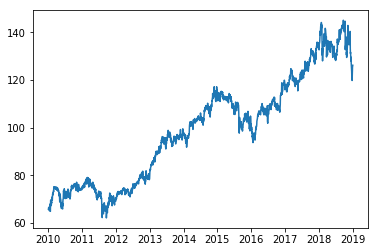

In [4]:
plt.plot_date(full_X,df.close,'-')

### HMM: Finance, Filtered Training Data

In [5]:
'''Train Models'''

hmm_models = []

for n in range(2,31):
    hmm = GaussianHMM(n_components=n,
                      covariance_type='diag',
                      algorithm='viterbi')
    hmm = hmm.fit(smooth_return_train*100)
    hmm_models.append(hmm)

hmm_means = np.array([hmm.means_ for hmm in hmm_models])
hmm_covars = np.array([hmm.covars_ for hmm in hmm_models])
hmm_transmats = np.array([hmm.transmat_ for hmm in hmm_models])

hmm_scores = np.array([hmm.score(smooth_return_train*100) for hmm in hmm_models])


In [6]:
'''Make Predictions'''
N_LATENCY = 10
hmm_predictions = []
hmm_predstates = []
hmm_returns = []

for hmm in hmm_models:
    predictions = []
    returns = []
    predstates = []
    for i in range(index_2017,len(df)):
        last_state = hmm.predict(smooth_return_full[i-N_LATENCY:i]*100)[-1] # the last state
        predstates.append(last_state)
        ## 1.expectation prob(state)*return(state)
        change_close = hmm.transmat_[last_state] @ hmm.means_[:,0]
        ## 2.pick most likely state
        #pred_state = np.argmax(hmm.transmat_[last_state])
        #change_close = hmm.means_[pred_state,0]
        ## 3.same state
        #change_close = hmm.means_[last_state,0]
        pred_close = close_full[i-1,0]*(1+change_close/100)
        returns.append(change_close)
        predictions.append(pred_close)
    predstates.append(hmm.predict(smooth_return_full[len(df)-N_LATENCY+1:len(df)]*100)[-1])
    hmm_predstates.append(predstates[1:])
    hmm_returns.append(returns)
    hmm_predictions.append(predictions)

hmm_predstates = np.array(hmm_predstates)
hmm_returns = np.array(hmm_returns)
hmm_predictions = np.array(hmm_predictions)


In [7]:
'''Compute Metrics'''

def pred_acc(y_true,y_pred,initial):
    assert len(y_true) == len(y_pred)
    total_len = len(y_true)
    y_true=np.insert(y_true,0,initial)
    y_pred=np.insert(y_pred,0,initial)
    correct = 0
    for i in range(1,total_len+1):
        if np.sign(y_true[i]-y_true[i-1]) == np.sign(y_pred[i]-y_pred[i-1]):
            correct += 1
    return correct/total_len


hmm_accs = np.array([pred_acc(close_full[index_2017:],predictions,close_full[index_2017-1])
                     for predictions in hmm_predictions])
hmm_mses = np.array([mean_squared_error(close_full[index_2017:],predictions) 
                     for predictions in hmm_predictions])


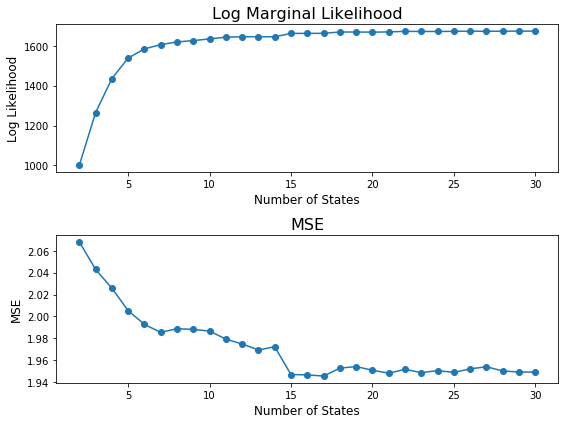

In [8]:
fig, axes = plt.subplots(2,1,figsize=(8,6))
axes[0].set_title('Log Marginal Likelihood',fontsize=16)
axes[0].plot(range(2,31),hmm_scores,'-o')
axes[0].set_xlabel('Number of States',fontsize=12)
axes[0].set_ylabel('Log Likelihood',fontsize=12)

axes[1].set_title('MSE',fontsize=16)
axes[1].plot(range(2,31),hmm_mses,'-o')
axes[1].set_xlabel('Number of States',fontsize=12)
axes[1].set_ylabel('MSE',fontsize=12)

# axes[2].set_title('Accuracy',fontsize=16)
# axes[2].plot(range(2,31),hmm_accs,'-o',label='5 states')
# axes[2].set_xlabel('Number of States',fontsize=12)
# axes[2].set_ylabel('Accuracy',fontsize=12);

plt.tight_layout()

#plt.savefig('fig/HMM_selectnumstates.png')

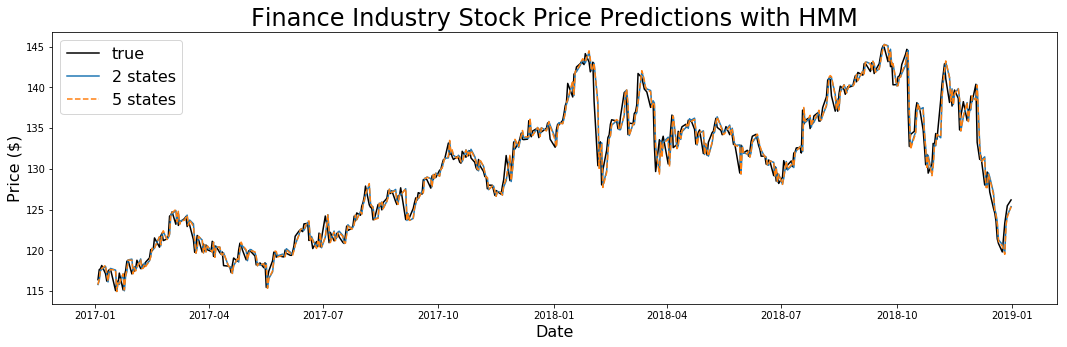

In [9]:
plt.figure(figsize=(18,5))
plt.title('Finance Industry Stock Price Predictions with HMM',fontsize=24)
n_pred=len(df)-index_2017
plt.plot_date(pred_X,close_full[index_2017:index_2017+n_pred],'-',c='k',label='true')
plt.plot_date(pred_X,hmm_predictions[0,:n_pred],'-',label='2 states')
plt.plot_date(pred_X,hmm_predictions[5-2,:n_pred],'--',label='5 states')
plt.legend(fontsize=16);

plt.xlabel('Date',fontsize=16)
plt.ylabel('Price ($)',fontsize=16);
#plt.savefig('fig/predictions_5state_filtered.png')

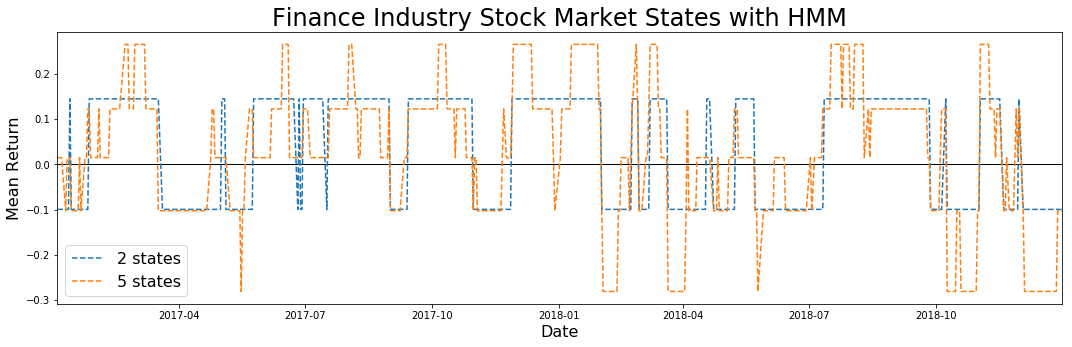

In [10]:
pred_state_return_2 = np.array([hmm_means[0][state,0] for state in hmm_predstates[0]])
pred_state_return_5 = np.array([hmm_means[3][state,0] for state in hmm_predstates[3]])

plt.figure(figsize=(18,5))
plt.title('Finance Industry Stock Market States with HMM',fontsize=24)
plt.axhline(0,c='k',linewidth=1)
plt.plot_date(pred_X,pred_state_return_2,'--',label='2 states')
plt.plot_date(pred_X,pred_state_return_5,'--',label='5 states')
plt.xlim(pred_X[0],pred_X[-1])
plt.xlabel('Date',fontsize=16)
plt.ylabel('Mean Return',fontsize=16)
plt.legend(fontsize=16);
#plt.savefig('fig/state_pred_filtered');

### HMM: Finance, *NOT* Filtered Training Data

In [11]:
'''Train Models'''

hmm_models_u = []

for n in range(2,31):
    hmm = GaussianHMM(n_components=n,
                      covariance_type='diag',
                      algorithm='viterbi')
    hmm = hmm.fit(return_train*100)
    hmm_models_u.append(hmm)

hmm_means_u = np.array([hmm.means_ for hmm in hmm_models_u])
hmm_covars_u = np.array([hmm.covars_ for hmm in hmm_models_u])
hmm_transmats_u = np.array([hmm.transmat_ for hmm in hmm_models_u])

hmm_scores_u = np.array([hmm.score(return_train*100) for hmm in hmm_models_u])


In [12]:
'''Make Predictions'''
N_LATENCY = 10
hmm_predictions_u = []
hmm_predstates_u = []
hmm_returns_u = []

for hmm in hmm_models_u:
    predictions = []
    returns = []
    predstates = []
    for i in range(index_2017,len(df)):
        last_state = hmm.predict(return_full[i-N_LATENCY:i]*100)[-1] # the last state
        predstates.append(last_state)
        ## 1.expectation prob(state)*return(state)
        change_close = hmm.transmat_[last_state] @ hmm.means_[:,0]
        ## 2.pick most likely state
        #pred_state = np.argmax(hmm.transmat_[last_state])
        #change_close = hmm.means_[pred_state,0]
        ## 3.same state
        #change_close = hmm.means_[last_state,0]
        pred_close = close_full[i-1,0]*(1+change_close/100)
        returns.append(change_close)
        predictions.append(pred_close)
    predstates.append(hmm.predict(return_full[len(df)-N_LATENCY+1:len(df)]*100)[-1])
    hmm_predstates_u.append(predstates[1:])
    hmm_returns_u.append(returns)
    hmm_predictions_u.append(predictions)

hmm_predstates_u = np.array(hmm_predstates_u)
hmm_returns_u = np.array(hmm_returns_u)
hmm_predictions_u = np.array(hmm_predictions_u)


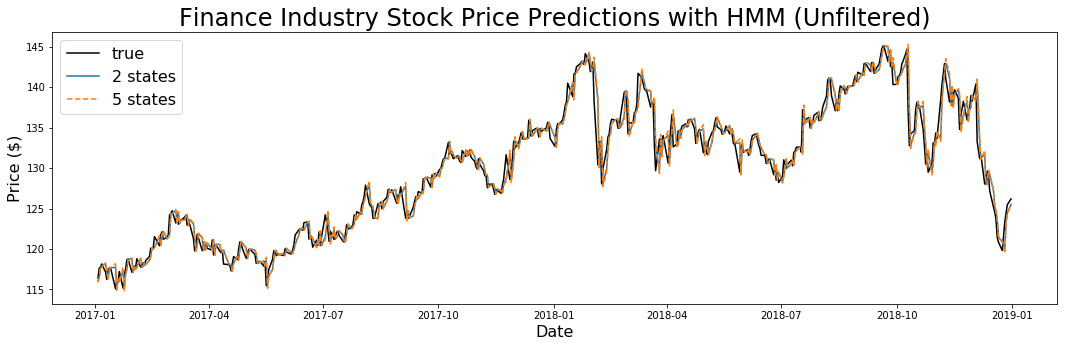

In [13]:
plt.figure(figsize=(18,5))
plt.title('Finance Industry Stock Price Predictions with HMM (Unfiltered)',fontsize=24)
n_pred=len(df)-index_2017
plt.plot_date(pred_X,close_full[index_2017:index_2017+n_pred],'-',c='k',label='true')
plt.plot_date(pred_X,hmm_predictions_u[0,:n_pred],'-',label='2 states')
plt.plot_date(pred_X,hmm_predictions_u[5-2,:n_pred],'--',label='5 states')
plt.legend(fontsize=16);

plt.xlabel('Date',fontsize=16)
plt.ylabel('Price ($)',fontsize=16);
#plt.savefig('fig/predictions_5state_unfiltered.png')

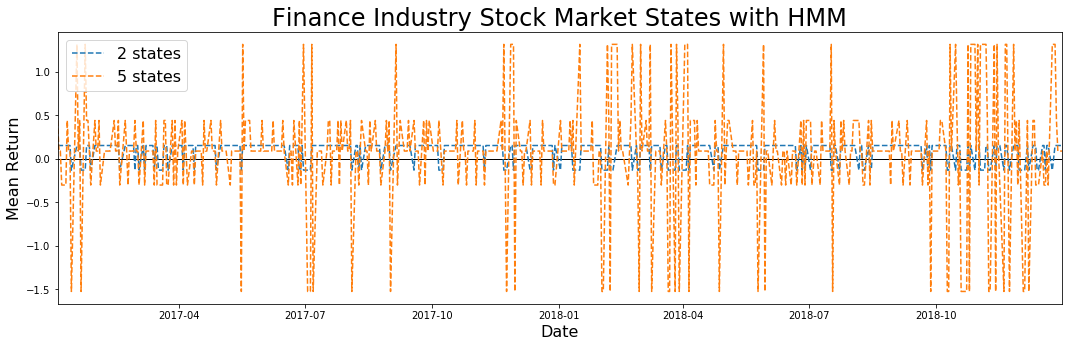

In [14]:
pred_state_return_2_u = np.array([hmm_means_u[0][state,0] for state in hmm_predstates_u[0]])
pred_state_return_5_u = np.array([hmm_means_u[3][state,0] for state in hmm_predstates_u[3]])

plt.figure(figsize=(18,5))
plt.title('Finance Industry Stock Market States with HMM',fontsize=24)
plt.axhline(0,c='k',linewidth=1)
plt.plot_date(pred_X,pred_state_return_2_u,'--',label='2 states')
plt.plot_date(pred_X,pred_state_return_5_u,'--',label='5 states')
plt.xlim(pred_X[0],pred_X[-1])
plt.xlabel('Date',fontsize=16)
plt.ylabel('Mean Return',fontsize=16)
plt.legend(fontsize=16);
#plt.savefig('fig/state_pred_unfiltered');

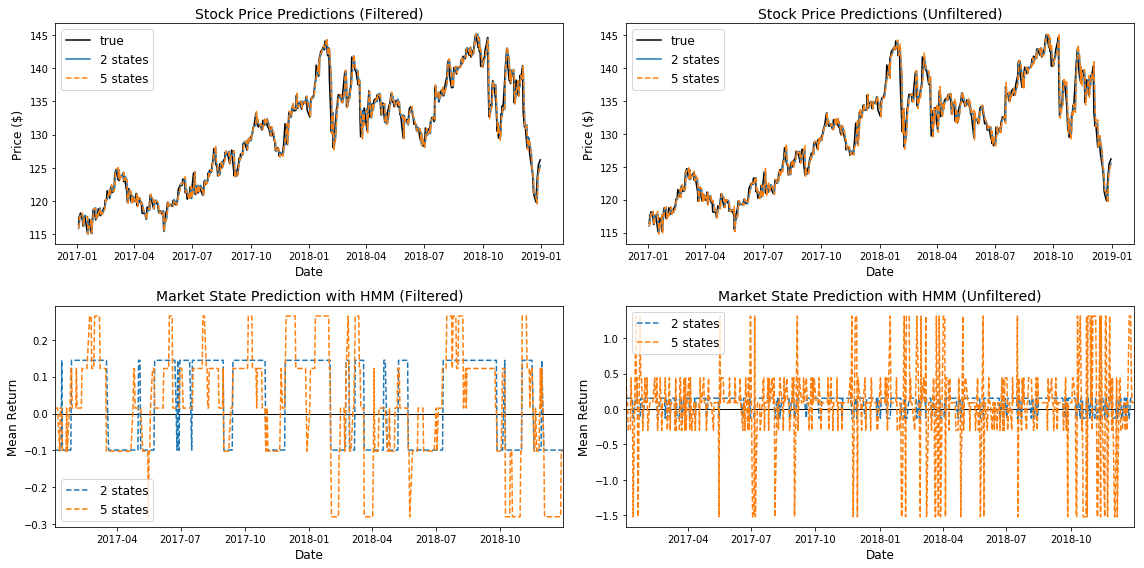

In [15]:
## Compile performance plots

fig,axes = plt.subplots(2,2,figsize=(16,8))

axes[0][0].set_title('Stock Price Predictions (Filtered)',fontsize=14)
n_pred=len(df)-index_2017
axes[0][0].plot_date(pred_X,close_full[index_2017:index_2017+n_pred],'-',c='k',label='true')
axes[0][0].plot_date(pred_X,hmm_predictions[0,:n_pred],'-',label='2 states')
axes[0][0].plot_date(pred_X,hmm_predictions[5-2,:n_pred],'--',label='5 states')
axes[0][0].legend(fontsize=12);
axes[0][0].set_xlabel('Date',fontsize=12)
axes[0][0].set_ylabel('Price ($)',fontsize=12);

axes[1][0].set_title('Market State Prediction with HMM (Filtered)',fontsize=14)
axes[1][0].axhline(0,c='k',linewidth=1)
axes[1][0].plot_date(pred_X,pred_state_return_2,'--',label='2 states')
axes[1][0].plot_date(pred_X,pred_state_return_5,'--',label='5 states')
axes[1][0].set_xlim(pred_X[0],pred_X[-1])
axes[1][0].set_xlabel('Date',fontsize=12)
axes[1][0].set_ylabel('Mean Return',fontsize=12)
axes[1][0].legend(fontsize=12);

axes[0][1].set_title('Stock Price Predictions (Unfiltered)',fontsize=14)
axes[0][1].plot_date(pred_X,close_full[index_2017:index_2017+n_pred],'-',c='k',label='true')
axes[0][1].plot_date(pred_X,hmm_predictions_u[0,:n_pred],'-',label='2 states')
axes[0][1].plot_date(pred_X,hmm_predictions_u[5-2,:n_pred],'--',label='5 states')
axes[0][1].legend(fontsize=12);
axes[0][1].set_xlabel('Date',fontsize=12)
axes[0][1].set_ylabel('Price ($)',fontsize=12);

axes[1][1].set_title('Market State Prediction with HMM (Unfiltered)',fontsize=14)
axes[1][1].axhline(0,c='k',linewidth=1)
axes[1][1].plot_date(pred_X,pred_state_return_2_u,'--',label='2 states')
axes[1][1].plot_date(pred_X,pred_state_return_5_u,'--',label='5 states')
axes[1][1].set_xlim(pred_X[0],pred_X[-1])
axes[1][1].set_xlabel('Date',fontsize=12)
axes[1][1].set_ylabel('Mean Return',fontsize=12)
axes[1][1].legend(fontsize=12);

plt.tight_layout()

#plt.savefig('fig/HMM_performance.png');

### HMM: Industry Comparison with Filtered Training Data

#### All Industries

In [16]:
df_industry = pd.read_csv('smooth_industry.csv')
display(df_industry.head(2))

INDUSTRIES=['Transportation','Finance','Manufactoring','Wholesale',
            'Services','Public','Construction','Retail','Mining']

,date,close_Transportation,smooth_Transportation,close_Finance,smooth_Finance,close_Manufactoring,smooth_Manufactoring,close_Wholesale,smooth_Wholesale,close_Services,smooth_Services,close_Public,smooth_Public,close_Construction,smooth_Construction,close_Retail,smooth_Retail,close_Mining,smooth_Mining
0,2010-01-05,22.823604,22.800803,65.830455,65.764691,20.195778,20.175603,19.462535,19.443092,18.636101,18.617484,14.008396,13.994401,27.807690,27.779911,21.030696,21.009687,21.387686,21.366320
1,2010-01-06,22.877452,22.839299,66.142888,65.954637,20.277470,20.226764,19.574467,19.509074,18.604432,18.610929,14.292948,14.144343,27.964614,27.872676,21.118698,21.064437,21.711506,21.539686


In [17]:
'''Train Models'''

hmm_models_allind = []
hmm_means_allind = []
hmm_covars_allind = []
hmm_transmats_allind = []
hmm_scores_allind = []

for ind in INDUSTRIES:
    smooth_return_train = compute_return(df_industry['smooth_'+ind].values[:1762]).reshape(-1,1)
    hmm_models_ind = []
    hmm_scores_ind = []
    for n in range(2,11):
        hmm = GaussianHMM(n_components=n,
                          covariance_type='diag',
                          algorithm='viterbi')
        hmm = hmm.fit(smooth_return_train*100)
        hmm_models_ind.append(hmm)
        hmm_scores_ind.append(hmm.score(smooth_return_train*100))
    hmm_models_allind.append(hmm_models_ind)
    hmm_scores_allind.append(hmm_scores_ind)

        
# hmm_means = np.array([hmm.means_ for hmm in hmm_models])
# hmm_covars = np.array([hmm.covars_ for hmm in hmm_models])
# hmm_transmats = np.array([hmm.transmat_ for hmm in hmm_models])

# hmm_scores = np.array([hmm.score(return_train) for hmm in hmm_models])

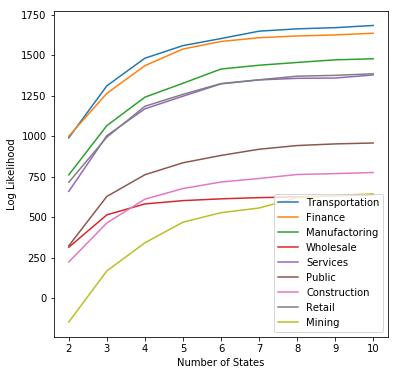

In [18]:
plt.figure(figsize=(6,6))
for ind in range(9):
    plt.plot(range(2,11),hmm_scores_allind[ind],label=INDUSTRIES[ind])
plt.xlabel('Number of States')
plt.ylabel('Log Likelihood')
plt.legend();

In [19]:
hmm_models_allind = np.array(hmm_models_allind)
hmm_means_5_allind = []
hmm_vars_5_allind = []
for hmm in hmm_models_allind[:,3]:
    hmm_means_5_allind.append(hmm.means_)
    hmm_vars_5_allind.append(hmm.covars_)
    
means_allind = np.squeeze(np.array(hmm_means_5_allind))
vars_allind = np.squeeze(np.array(hmm_vars_5_allind))

In [20]:
states_allind = np.zeros((9,5,2))
for ind in range(9):
    for state in range(5):
        states_allind[ind,state,0] = means_allind[ind,state]
        states_allind[ind,state,1] = vars_allind[ind,state]

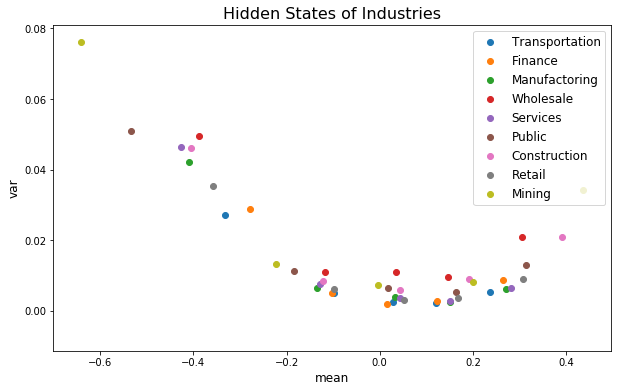

In [21]:
plt.figure(figsize=(10,6))
plt.title('Hidden States of Industries',fontsize=16)
for i in range(9):#
    plt.scatter(states_allind[i,:,0],states_allind[i,:,1],label=INDUSTRIES[i])
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('mean',fontsize=12)
plt.ylabel('var',fontsize=12);
#plt.savefig('fig/HMM_industry_states.png');

#### Impact of Supply Chain

Text(0, 0.5, 'var')

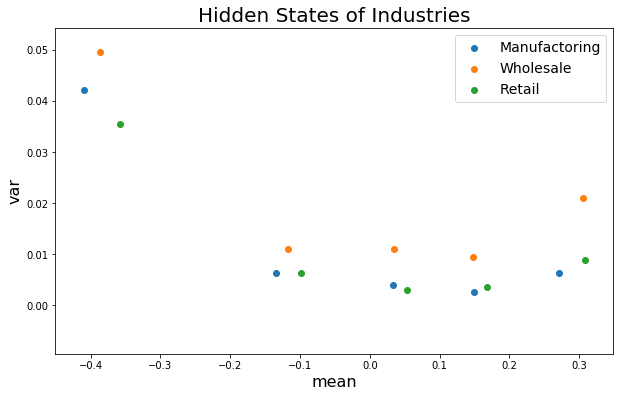

In [22]:
plt.figure(figsize=(10,6))
plt.title('Hidden States of Industries',fontsize=20)
for i in [2,3,7]:
    plt.scatter(states_allind[i,:,0],states_allind[i,:,1],label=INDUSTRIES[i])
plt.legend(fontsize=14)
plt.xlabel('mean',fontsize=16)
plt.ylabel('var',fontsize=16)
#plt.savefig('fig/states_manu_whole_ret.png')

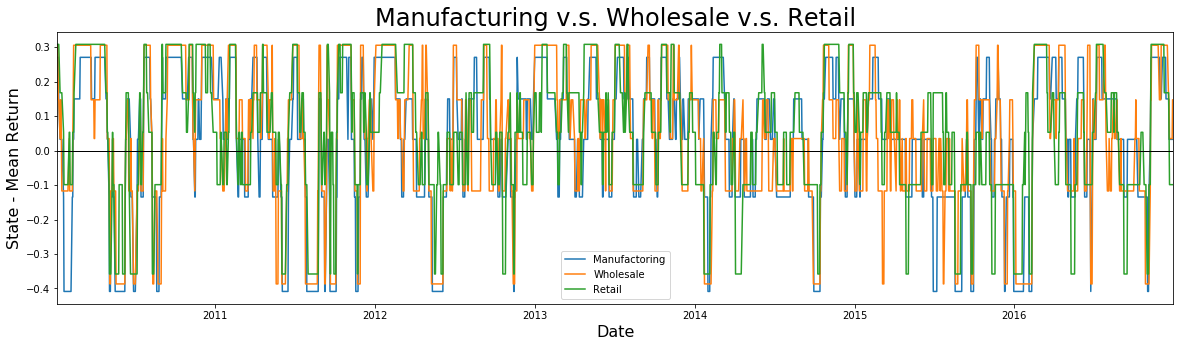

In [23]:
plt.figure(figsize=(20,5))
plt.title('Manufacturing v.s. Wholesale v.s. Retail', fontsize=24)
for i in [2,3,7]:
    smooth_return_train = compute_return(df_industry['smooth_'+INDUSTRIES[i]].values[:1762]).reshape(-1,1)
    hmm = hmm_models_allind[i,3]
    state_seq = hmm.predict(smooth_return_train*100)
    mean_seq = [hmm.means_[state] for state in state_seq]
    plt.plot_date(train_X,mean_seq,'-',label=INDUSTRIES[i])
plt.legend()
plt.axhline(0,c='k',linewidth=1)
plt.xlim(train_X[0],train_X[-1])
plt.xlabel('Date',fontsize=16)
plt.ylabel('State - Mean Return',fontsize=16);
#plt.savefig('fig/manufacturing_wholesale_retial.png');

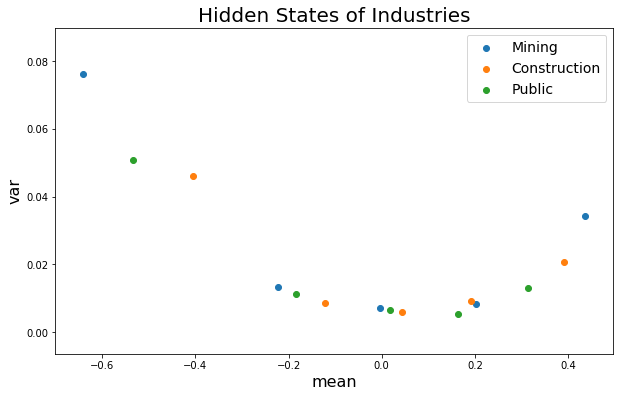

In [24]:
plt.figure(figsize=(10,6))
plt.title('Hidden States of Industries',fontsize=20)
for i in [8,6,5]:
    plt.scatter(states_allind[i,:,0],states_allind[i,:,1],label=INDUSTRIES[i])
plt.legend(fontsize=14)
plt.xlabel('mean',fontsize=16)
plt.ylabel('var',fontsize=16);
#plt.savefig('fig/states_manu_whole_ret.png')

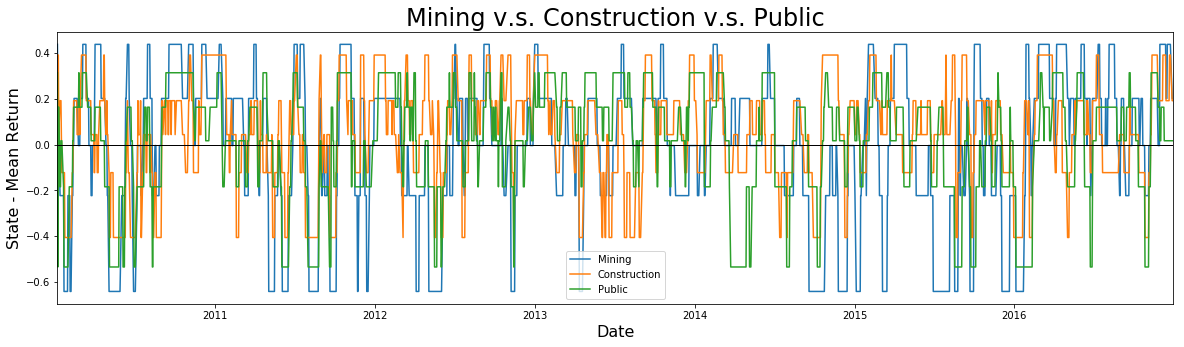

In [25]:
plt.figure(figsize=(20,5))
plt.title('Mining v.s. Construction v.s. Public', fontsize=24)
for i in [8,6,5]:
    smooth_return_train = compute_return(df_industry['smooth_'+INDUSTRIES[i]].values[:1762]).reshape(-1,1)
    hmm = hmm_models_allind[i,3]
    state_seq = hmm.predict(smooth_return_train*100)
    mean_seq = [hmm.means_[state] for state in state_seq]
    plt.plot_date(train_X,mean_seq,'-',label=INDUSTRIES[i])
plt.legend()
plt.axhline(0,c='k',linewidth=1)
plt.xlim(train_X[0],train_X[-1])
plt.xlabel('Date',fontsize=16)
plt.ylabel('State - Mean Return',fontsize=16);
#plt.savefig('fig/manufacturing_wholesale_retial.png');

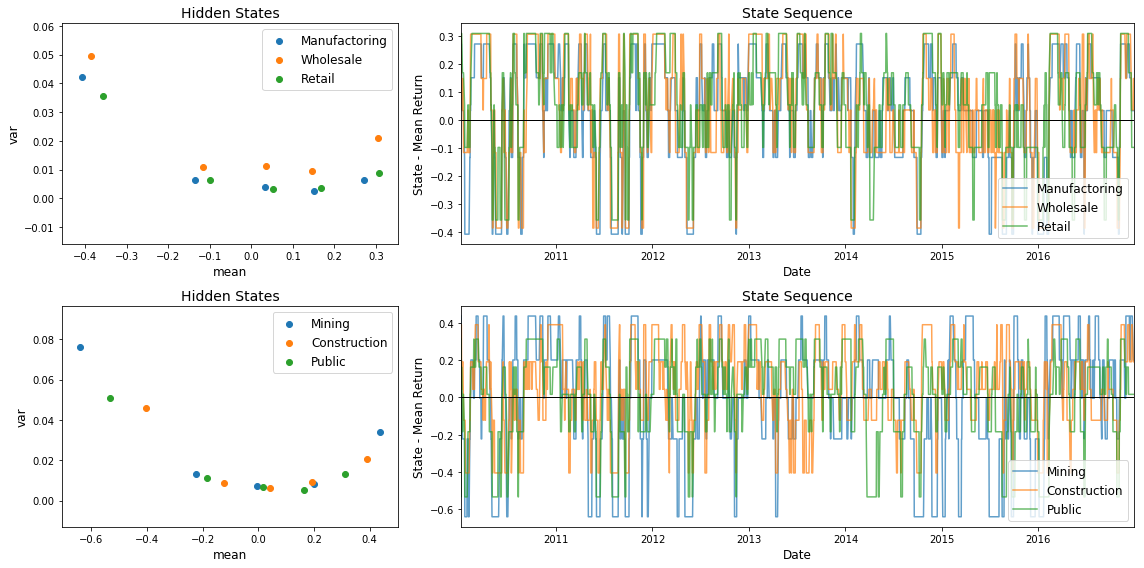

In [26]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 8)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2]) 

ax0 = plt.subplot(gs[0])
ax0.set_title('Hidden States',fontsize=14)
for i in [2,3,7]:
    ax0.scatter(states_allind[i,:,0],states_allind[i,:,1],label=INDUSTRIES[i])
ax0.legend(fontsize=12)
ax0.set_xlabel('mean',fontsize=12)
ax0.set_ylabel('var',fontsize=12)

ax1 = plt.subplot(gs[1])
ax1.set_title('State Sequence', fontsize=14)
for i in [2,3,7]:
    smooth_return_train = compute_return(df_industry['smooth_'+INDUSTRIES[i]].values[:1762]).reshape(-1,1)
    hmm = hmm_models_allind[i,3]
    state_seq = hmm.predict(smooth_return_train*100)
    mean_seq = [hmm.means_[state] for state in state_seq]
    ax1.plot_date(train_X,mean_seq,'-',alpha=0.7,label=INDUSTRIES[i])
ax1.legend(loc='lower right',fontsize=12)
ax1.axhline(0,c='k',linewidth=1)
ax1.set_xlim(train_X[0],train_X[-1])
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('State - Mean Return',fontsize=12);

ax2 = plt.subplot(gs[2])
ax2.set_title('Hidden States',fontsize=14)
for i in [8,6,5]:
    ax2.scatter(states_allind[i,:,0],states_allind[i,:,1],label=INDUSTRIES[i])
ax2.legend(fontsize=12)
ax2.set_xlabel('mean',fontsize=12)
ax2.set_ylabel('var',fontsize=12)

ax3 = plt.subplot(gs[3])
ax3.set_title('State Sequence', fontsize=14)
for i in [8,6,5]:
    smooth_return_train = compute_return(df_industry['smooth_'+INDUSTRIES[i]].values[:1762]).reshape(-1,1)
    hmm = hmm_models_allind[i,3]
    state_seq = hmm.predict(smooth_return_train*100)
    mean_seq = [hmm.means_[state] for state in state_seq]
    ax3.plot_date(train_X,mean_seq,'-',alpha=0.7,label=INDUSTRIES[i])
ax3.legend(loc='lower right',fontsize=12)
ax3.axhline(0,c='k',linewidth=1)
ax3.set_xlim(train_X[0],train_X[-1])
ax3.set_xlabel('Date',fontsize=12)
ax3.set_ylabel('State - Mean Return',fontsize=12);

plt.tight_layout();
#plt.savefig('fig/HMM_indchain.png');

#### Performance of Cyclical Industry

Sample Industries: Finance, Mining, Manufacturing

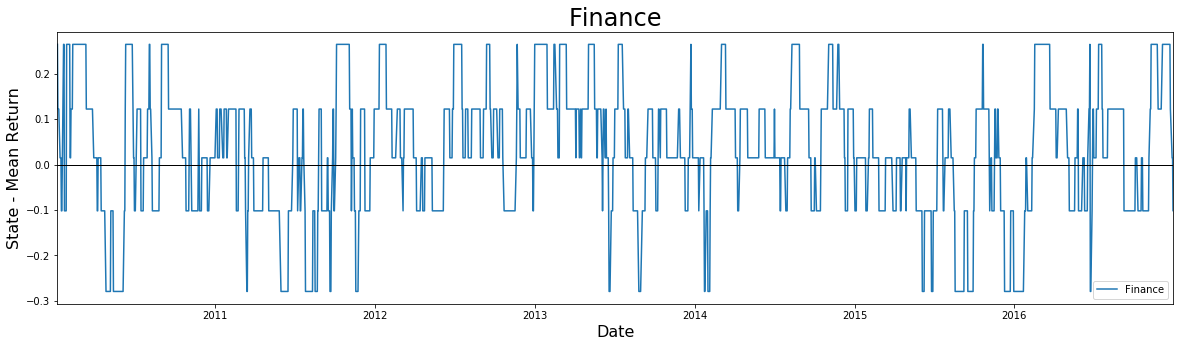

In [27]:
plt.figure(figsize=(20,5))
plt.title('Finance', fontsize=24)
for i in [1]:
    smooth_return_train = compute_return(df_industry['smooth_'+INDUSTRIES[i]].values[:1762]).reshape(-1,1)
    hmm = hmm_models_allind[i,3]
    state_seq = hmm.predict(smooth_return_train*100)
    mean_seq = [hmm.means_[state] for state in state_seq]
    plt.plot_date(train_X,mean_seq,'-',label=INDUSTRIES[i])
plt.legend()
plt.axhline(0,c='k',linewidth=1)
plt.xlim(train_X[0],train_X[-1])
plt.xlabel('Date',fontsize=16)
plt.ylabel('State - Mean Return',fontsize=16);
#plt.savefig('fig/seq_finance.png');

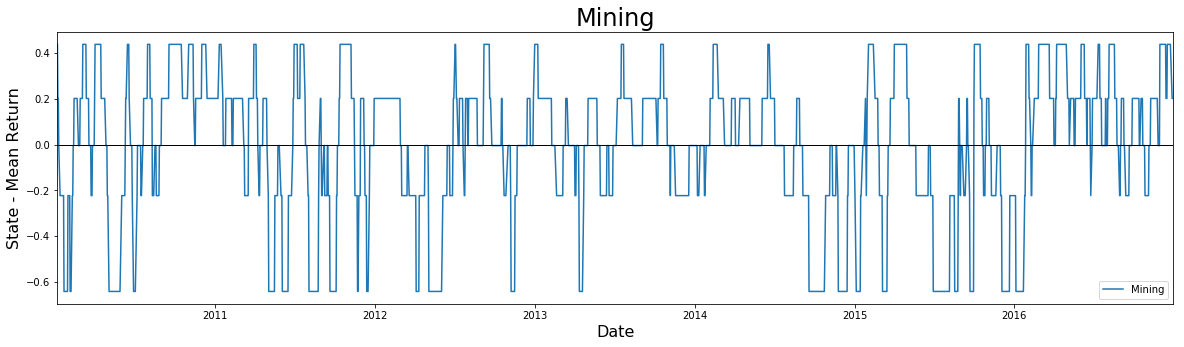

In [28]:
plt.figure(figsize=(20,5))
plt.title('Mining', fontsize=24)
for i in [8]:
    smooth_return_train = compute_return(df_industry['smooth_'+INDUSTRIES[i]].values[:1762]).reshape(-1,1)
    hmm = hmm_models_allind[i,3]
    state_seq = hmm.predict(smooth_return_train*100)
    mean_seq = [hmm.means_[state] for state in state_seq]
    plt.plot_date(train_X,mean_seq,'-',label=INDUSTRIES[i])
plt.legend()
plt.axhline(0,c='k',linewidth=1)
plt.xlim(train_X[0],train_X[-1])
plt.xlabel('Date',fontsize=16)
plt.ylabel('State - Mean Return',fontsize=16);
#plt.savefig('fig/seq_finance.png');

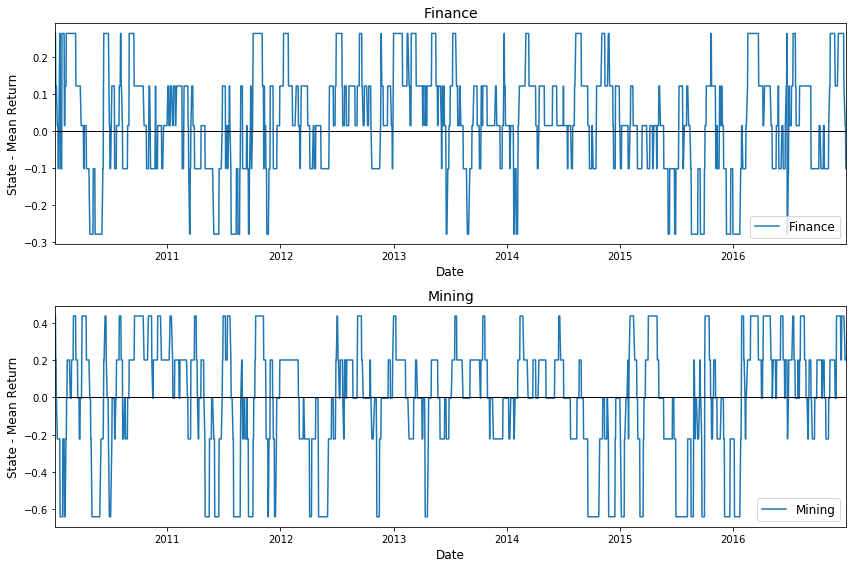

In [29]:
fig,axes = plt.subplots(2,1,figsize=(12,8))
#fig.suptitle('State Sequence', fontsize=18)

axes[0].set_title('Finance', fontsize=14)
for i in [1]:
    smooth_return_train = compute_return(df_industry['smooth_'+INDUSTRIES[i]].values[:1762]).reshape(-1,1)
    hmm = hmm_models_allind[i,3]
    state_seq = hmm.predict(smooth_return_train*100)
    mean_seq = [hmm.means_[state] for state in state_seq]
    axes[0].plot_date(train_X,mean_seq,'-',label=INDUSTRIES[i])
axes[0].legend(loc='lower right',fontsize=12)
axes[0].axhline(0,c='k',linewidth=1)
axes[0].set_xlim(train_X[0],train_X[-1])
axes[0].set_xlabel('Date',fontsize=12)
axes[0].set_ylabel('State - Mean Return',fontsize=12);

axes[1].set_title('Mining', fontsize=14)
for i in [8]:
    smooth_return_train = compute_return(df_industry['smooth_'+INDUSTRIES[i]].values[:1762]).reshape(-1,1)
    hmm = hmm_models_allind[i,3]
    state_seq = hmm.predict(smooth_return_train*100)
    mean_seq = [hmm.means_[state] for state in state_seq]
    axes[1].plot_date(train_X,mean_seq,'-',label=INDUSTRIES[i])
axes[1].legend(loc='lower right',fontsize=12)
axes[1].axhline(0,c='k',linewidth=1)
axes[1].set_xlim(train_X[0],train_X[-1])
axes[1].set_xlabel('Date',fontsize=12)
axes[1].set_ylabel('State - Mean Return',fontsize=12);

plt.tight_layout();
#plt.savefig('fig/HMM_cyclicind.png');

### Comparison between HMM and VAE

In [30]:
result = hmm_models[3].predict(smooth_return_train)
#np.savetxt('2010-2016hiddenstates_5states.txt',result)
